In [12]:
from scipy.io import loadmat
import numpy as np
import pandas as pd

In [13]:
base_data = pd.read_csv('/data/sourcedata/magRiskData2.csv', index_col=[0,1,2])
base_data.index.set_names('subject', level=0, inplace=True)
base_data['trial_nr'] = base_data.groupby(['subject', 'exptype']).cumcount() + 1
base_data.set_index('trial_nr', append=True, inplace=True)

In [14]:
base_data['chose_risky'] = base_data['choice'] == -1
base_data.loc[~np.in1d(base_data.choice, [-1, 1]), 'chose_risky'] = np.nan
base_data['chose_risky'] = base_data['chose_risky'].astype(float)

In [15]:
base_data['x'] = np.log(base_data['prob_bet'] / base_data['sure_bet'])

In [16]:
tmp = loadmat('/data/sourcedata/sub_01_UF/sub_01_run_01_UF_resPar_02_riskComp_02_taskSeq_04.mat', squeeze_me=True, simplify_cells=True)['magRiskTrial']

tmp.keys()

dict_keys(['area', 'accuracy', 'rt', 'leftRight', 'cueOneDuration', 'cueTwoDuration', 'stimDuration', 'responseDuration', 'responseCueDuration', 'remainDuration', 'ITIvariation', 'trialDuration', 'trialAccumulation', 'xpos', 'ypos', 'firststim_dot', 'secondstim_dot', 's1', 's2', 'diffVal', 'correct', 'total', 'trialSet', 'trialSet_perm1', 's1_perm', 's2_perm', 'diffVal_perm', 'correct_perm', 's1Rep_perm', 'reset', 's1_Reduc', 's2_Reduc', 'stimSeq', 'sequence', 's2Prob_perm', 'diffVal_perm2', 'correct_perm2', 'trialSet_perm2', 'nTrials', 'rangeMax', 'nTrialsMax', 'prob', 'selectedTrial', 'pressedKey', 'constSide', 'rad', 'cueOnset1', 'cueOffset1', 'cueOnset2', 'cueOffset2', 'stimOnset', 'stimOffset', 'responseOnset1', 'responseOnset2', 'responseOffset', 'remainOnset', 'remainOffset', 'cueDiff1', 'cueDiff2', 'stimDiff', 'responseDiff1', 'responseDiff2', 'remainDiff', 'rt2', 'dataFile'])

In [17]:
def load_behavior(fn):
    data = loadmat(fn, squeeze_me=True, simplify_cells=True)['magRiskTrial']

    fields = ['accuracy', 'rt', 'leftRight', 'pressedKey', 's1_perm', 's2_perm', 'constSide', 'correct_perm', 'reset']
    data = pd.DataFrame(dict((k, data[k]) for k in fields))

    return data

In [18]:
import glob
import os.path as op
import re

source_folder = '/data/ds-riskeye/sourcedata'
# def load_risk_data()

subject = '63'
reg = re.compile(f'.*/sub_{subject}_run_(?P<run>[0-9]+).+riskComp_(?P<task>[0-9]+)_taskSeq_(?P<block>[0-9]+)\.mat')

fns = sorted(glob.glob(op.join(source_folder, f'sub_{subject}*', f'sub_{subject}*resPar_02_riskComp_*_taskSeq_*.mat')))

df =  []
keys = []
for fn in fns:
    df.append(load_behavior(fn))
    info = reg.match(fn).groupdict()
    keys.append((int(subject), int(info['run']), int(info['task']), int(info['block'])))

df = pd.concat(df, keys=keys, names=['subject', 'run', 'exptype', 'block']).droplevel(-1)
df['trial_nr'] = df.groupby(['subject', 'exptype']).cumcount() + 1
df.set_index('trial_nr', append=True, inplace=True)

ValueError: No objects to concatenate

In [552]:
df = df.rename(columns={'s1_perm':'n_safe', 's2_perm':'n_risky'})
# df['ev_risky'] = 

In [553]:
reset1 = df.reset == 1
df['n_left'] = df['n_risky'].where(reset1, df['n_safe'])
df['n_right'] = df['n_risky'].where(~reset1, df['n_safe'])
df['p_left'] = df['p_right'] = 0.55
df['p_left'] = df['p_left'].where(reset1, 1.0)
df['p_right'] = df['p_right'].where(~reset1, 1.0)

In [554]:
df['chose_risky'] = ((df['leftRight'] == 1) & (df['reset'] == -1)) | ((df['leftRight'] == -1) & (df['reset'] == 1))

In [555]:
import matplotlib.pyplot as plt

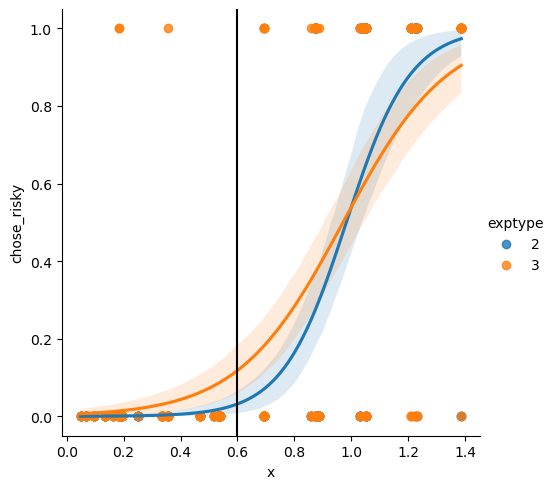

In [556]:
df['x'] = np.log(df['n_risky'] / df['n_safe'])

sns.lmplot(data=df.reset_index(), x='x', y='chose_risky', hue='exptype', logistic=True)
plt.axvline(np.log(1./.55), c='k')

In [544]:
base_data.groupby(['exptype', 'type']).size()

exptype  type
1        0       13824
2        0       15360
3        1       15360
dtype: int64

In [559]:
df.join(base_data, lsuffix='_new', rsuffix='_old')

accuracy    rt  leftRight  pressedKey  \
subject run exptype trial_nr block                                          
63      1   2       1        2             0  1350         -1          77   
                    2        2             1  1278         -1          77   
                    3        2             1  1163         -1          77   
                    4        2             1   898         -1          77   
                    5        2             0  1160         -1          77   
...                                      ...   ...        ...         ...   
        5   3       236      4             1   682         -1          77   
                    237      4            -1    -1         -2          -1   
                    238      4             1  1135         -1          77   
                    239      4             1   676          1          75   
                    240      4             1   623          1          75   

                                    n_safe  n_risky  constSide  correct_perm  \
subject run exptype trial_nr block                                             
63      1   2       1        2           7       14          0            -1   
                    2        2          20       34          0             1   
                    3        2          10       17          0             1   
                    4        2           5        6          0             1   
                    5        2          28       56          0            -1   
...                                    ...      ...        ...           ...   
        5   3       236      4          28       94          0            -1   
                    237      4          14       47          0            -1   
                    238      4          20       57          0            -1   
                    239      4          14       20          0             1   
                    240      4           5        8          0             1   

                                    reset  n_left  ...  p_right  \
subject run exptype trial_nr block                 ...            
63      1   2       1        2         -1       7  ...     0.55   
                    2        2         -1      20  ...     0.55   
                    3        2         -1      10  ...     0.55   
                    4        2         -1       5  ...     0.55   
                    5        2         -1      28  ...     0.55   
...                                   ...     ...  ...      ...   
        5   3       236      4          1      94  ...     1.00   
                    237      4          1      47  ...     1.00   
                    238      4          1      57  ...     1.00   
                    239      4          1      20  ...     1.00   
                    240      4          1       8  ...     1.00   

                                    chose_risky_new     x_new  sure_bet  \
subject run exptype trial_nr block                                        
63      1   2       1        2                False  0.693147         7   
                    2        2                False  0.530628        20   
                    3        2                False  0.530628        10   
                    4        2                False  0.182322         5   
                    5        2                False  0.693147        28   
...                                             ...       ...       ...   
        5   3       236      4                 True  1.211090        28   
                    237      4                False  1.211090        14   
                    238      4                 True  1.047319        20   
                    239      4                False  0.356675        14   
                    240      4                False  0.470004         5   

                                    prob_bet  choice  prob  type  \
subject run exptype trial_nr block                                 
63      1